This notebook tests the full functionality of the echo state network, but primarily verifies that it is capable of performing in generative forecasting tasks. It isn't optimised for this specific mackey-glass setup, but that could be achieved through various parameter searching algorithms. What matters is that this works with or without bias. Feedback should always be disabled in this use case.

It's worth noting that highly generalised ESNs require large reservoirs, i.e. N > 10^4. This is quite unlikely to run on CPU. Most modern networks will leverage some degree of GPU optimisation. But this code does demonstrate proof of concept and some functionalities.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyEchoStateNetwork.ESN_class import *

In [2]:
def mackey_glass(tau=17, beta=0.2, gamma=0.1, n=10, length=2000, dt=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    x = np.zeros(length)
    x[0] = 1.5  # Initial condition

    for t in range(1, length):
        t_tau = t - int(tau / dt)
        if t_tau < 0:
            x_tau = 0
        else:
            x_tau = x[t_tau]

        x[t] = x[t-1] + dt * (beta * x_tau / (1 + x_tau**n) - gamma * x[t-1])

    return x

# Generate the series
mg_series = mackey_glass(length=10000, dt=0.1, seed=42)

In [3]:
# Normalising, followed by train-test-split
mg_series = (mg_series - np.min(mg_series)) / (np.max(mg_series) - np.min(mg_series))

# Train-test split
train_length = 8000
test_length = 2000
mg_train = mg_series[:train_length]
mg_test = mg_series[train_length:train_length + test_length]

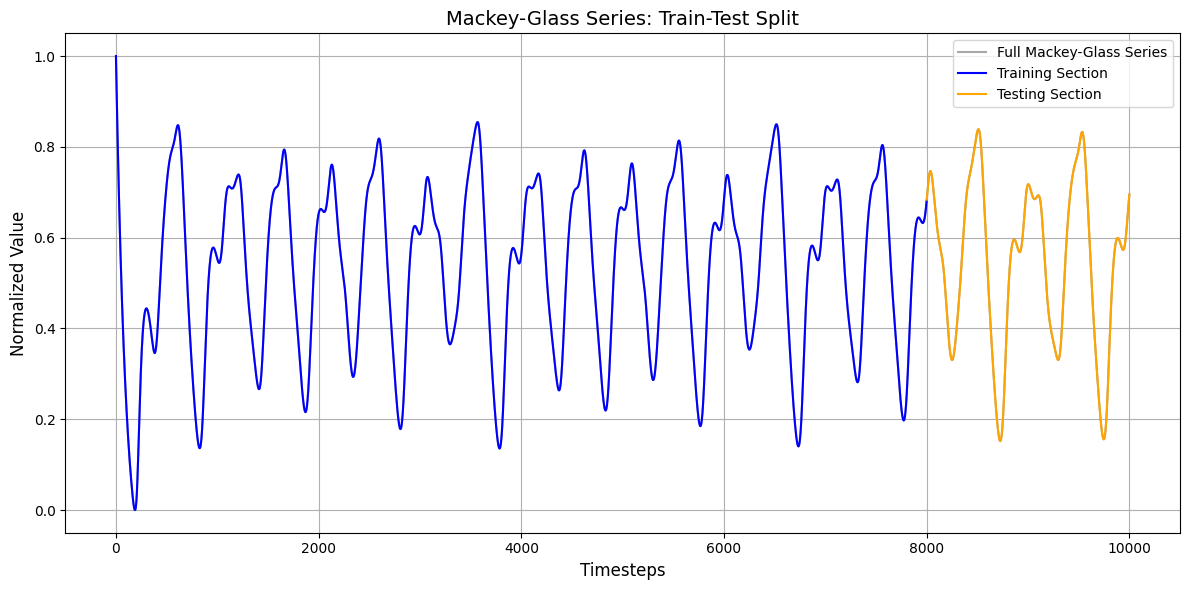

In [4]:
# Plotting the full series, training section, and testing section
plt.figure(figsize=(12, 6))

# Full series
plt.plot(mg_series, label='Full Mackey-Glass Series', color='gray', alpha=0.7)

# Training section
plt.plot(range(train_length), mg_train, label='Training Section', color='blue')

# Testing section
plt.plot(range(train_length, train_length + test_length), mg_test, label='Testing Section', color='orange')

# Formatting the plot
plt.title("Mackey-Glass Series: Train-Test Split", fontsize=14)
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()

In [5]:
# Validate that the dataset shapes are compatible with the ESN.
# Reshape for ESN.
mg_train_input = mg_train[:-1].reshape(1, -1)  # Input: all except last point.
mg_train_target = mg_train[1:].reshape(1, -1)  # Target: all except first point.

mg_test_input = mg_test[:-1].reshape(1, -1)
mg_test_target = mg_test[1:].reshape(1, -1)

# Printing their shapes.
print(f"mg_train_input shape: {mg_train_input.shape}")  # Should be (1, train_length - 1)
print(f"mg_train_target shape: {mg_train_target.shape}")  # Should be (1, train_length - 1)

print(f"mg_test_input shape: {mg_test_input.shape}")  # Should be (1, test_length - 1)
print(f"mg_test_target shape: {mg_test_target.shape}")  # Should be (1, test_length - 1)")

mg_train_input shape: (1, 7999)
mg_train_target shape: (1, 7999)
mg_test_input shape: (1, 1999)
mg_test_target shape: (1, 1999)


In [6]:
ESN_params = {
    "input_dim": 1,              # Number of input features (K).
    "nodes": 500,                # Number of reservoir neurons (N).
    "output_dim": 1,             # Number of output features (L).
    "distribution": "uniform",   # Weight distribution: "uniform" or "normal".
    "leak": 0.05,                 # Leak rate of the reservoir.
    "connectivity": 0.1,         # Sparsity level of the reservoir matrix.
    "input_scaling": np.array([0.4]).reshape(-1, 1),  # Scaling factor for input weights (K, 1).
    "spectral_radius": 1.25,      # Spectral radius of the reservoir.
    "noise": 0.001,               # Level of noise to inject into the reservoir state.
    "enable_feedback": False,     # Whether to enable teacher forcing (feedback).
    "teacher_scaling": np.array([1.0]).reshape(-1, 1),  # Scaling factor for feedback weights (L, 1).
    "seed": 42,                  # Seed for random number generation.
    "bias": False                # Whether to include a bias in the input and output layers.
}

Reservoir adjacency matrix initialized. Beginning spectral radius scaling.
The largest eigenvalue of this matrix was: 4.2482862936251315
Reservoir spectral radius scaled to: 1.2499999999975266
Reservoir weights spectral radius scaling completed.


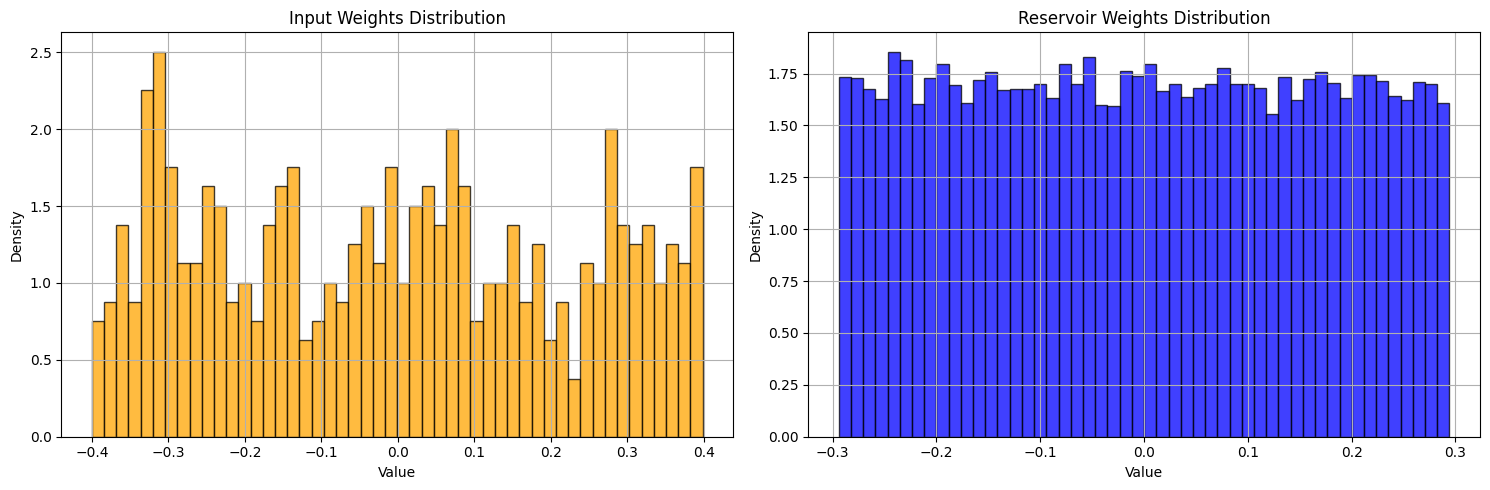


=== Matrix Shapes ===
Matrix         Shape               
-----------------------------------
W_res          (500, 500)          
W_in           (500, 1)            
W_fb           None                
Reservoir Adjacency Matrix is of type <class 'scipy.sparse._csr.csr_matrix'> with shape (500, 500)
Network matrices uploaded to C:\Users\dafyd\PycharmProjects\pyESN-library\Generated_Weights


In [7]:
# Initialising the ESN. Generating and displaying the weight matrices that define the network.
esn = EchoStateNetwork(ESN_params=ESN_params, verbose=2)
esn.initialize_reservoir()

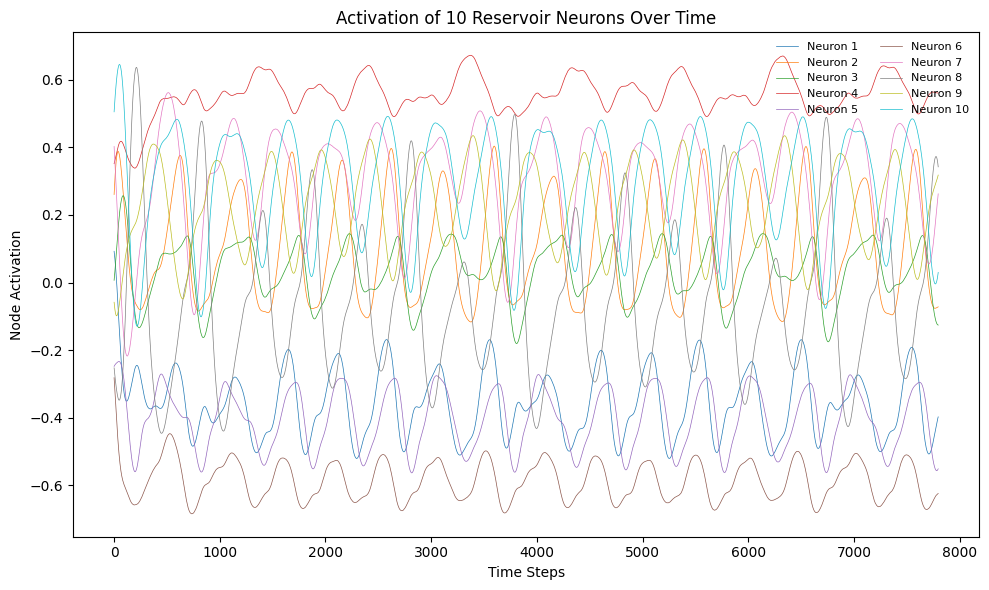

XX^T has shape: (501, 501)
YX^T has shape: (1, 501)


In [8]:
# Acquiring the reservoir states. These are used for training and for creating the precursors to the forecasting algorithm.
states = esn.acquire_reservoir_states(inputs=mg_train_input, teachers=mg_train_target, visualized_neurons=10, burn_in=200)

Readout weight matrix shape: (1, 501)


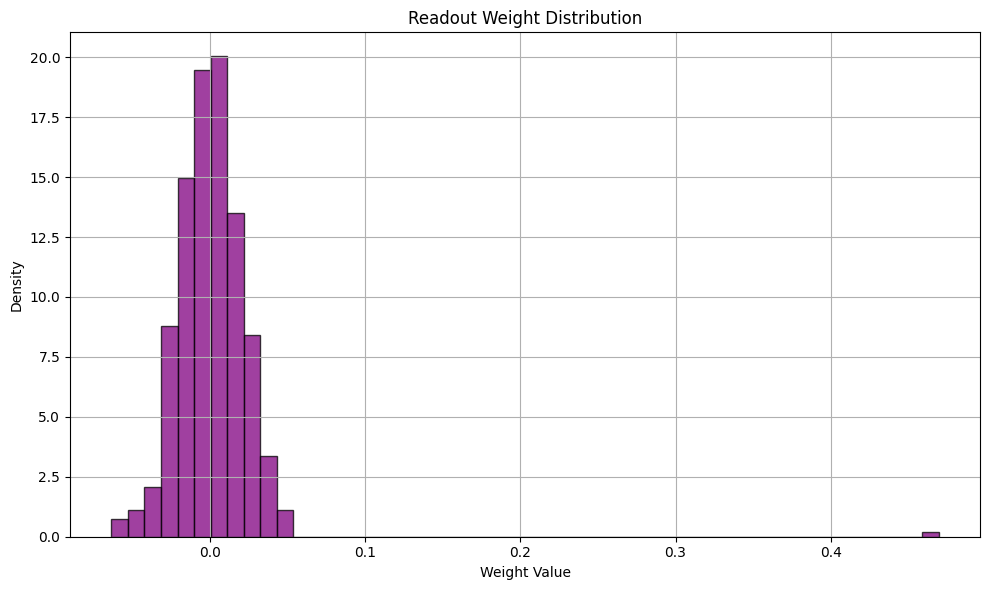

array([[ 4.69508871e-01, -1.47710794e-02, -6.54059713e-03,
         3.10467157e-02,  2.12096803e-02, -1.02210390e-02,
        -1.21404593e-02,  3.80015133e-02,  7.27154015e-04,
         3.56597969e-02, -2.29800916e-02, -2.04080508e-02,
         2.25666454e-02,  1.32480437e-02,  2.16156936e-03,
        -1.78765659e-02,  1.92311227e-02,  2.89147582e-02,
        -9.26210638e-03,  3.13557112e-02, -2.20491988e-02,
        -2.20642161e-02, -4.79797931e-03, -8.28316126e-03,
        -1.12485578e-02, -4.42913019e-04, -3.76534813e-03,
        -2.90656584e-02,  1.21219175e-02,  2.72167810e-02,
        -1.31009352e-02, -1.45576168e-02, -6.31134120e-02,
         1.31970953e-02, -2.51827133e-02,  6.48639900e-03,
         9.36437307e-03, -5.29226784e-03, -1.72258701e-02,
        -1.51775905e-02,  5.63081816e-03, -1.52957940e-02,
         2.38402328e-02, -2.24050377e-02,  2.29210981e-02,
         6.18934340e-03, -3.96858506e-02, -9.60664888e-03,
        -7.88107587e-03, -1.61413055e-02, -1.46273393e-0

In [9]:
# Performing ridge regression to train W_out.
ridge_param = 1e-1
esn.tikhonov_regression(ridge=ridge_param)

In [10]:
# Starting point for forecasting
initial_input = mg_train[-1].reshape(1, 1)  # Last point in training as starting point
forecast_horizon = test_length

# Perform generative forecasting
predicted, _ = esn.generative_forecast(T1=forecast_horizon, u1=initial_input)

In [11]:
predicted.shape

(1, 2000)

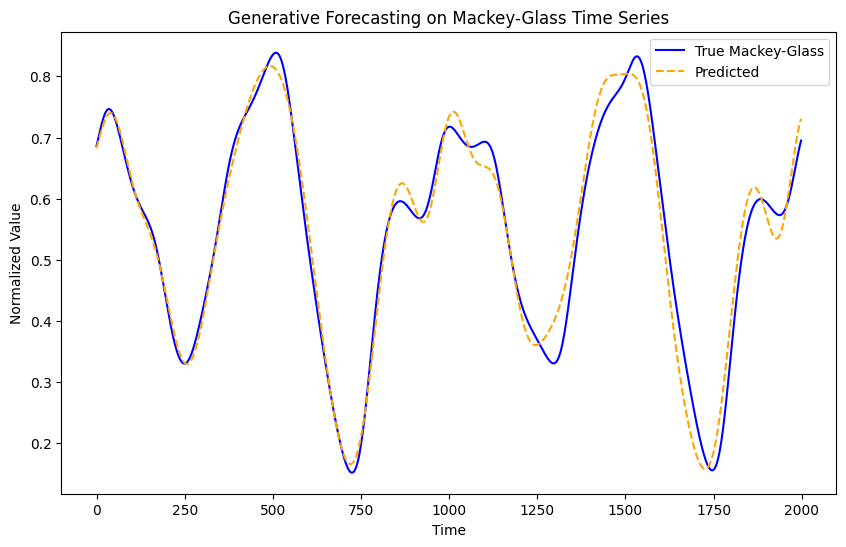

Mean Squared Error: 0.000960


In [12]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(mg_test[1:], label="True Mackey-Glass", color="blue", linewidth=1.5)
plt.plot(predicted.flatten()[:len(mg_test[1:])], label="Predicted", color="orange", linestyle="--", linewidth=1.5)
plt.legend()
plt.title("Generative Forecasting on Mackey-Glass Time Series")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.show()

# Calculate Mean Squared Error
mse = np.mean((predicted.flatten()[:len(mg_test[1:])] - mg_test[1:])**2)
print(f"Mean Squared Error: {mse:.6f}")